# Regex in Pandas

**Inhalt:** Regular Expressions in Pandas anwenden

**Nötige Skills:** Regex in Python

**Lernziele:**
- Ein praktisches Beispiel kennenlernen, wo Regex nützlich sein kann

# Das Beispiel

Das Bundesamt für Statistik stellt oft Dateien in verknorkster Form zur Verfügung, zum Beispiel, wenn man Auswertungen nach Gemeinden, Bezirken und Kantonen über das interaktive Portal generieren lässt: https://www.pxweb.bfs.admin.ch/pxweb/de/

Das vorliegende Beispiel beinhaltet die Bevölkerungszahlen, gegliedert nach Zivilstand einerseits (ledig, verheiratet, etc) und nach räumlicher Struktur (Gemeinden, Bezirke, Kantone) andererseits.

Das File ist gespeichert unter `dataprojects/BFS/px-x-0102010000_103.xlsx`

Unser 1. Ziel ist: Wir wollen die Tabelle filtern
- nur die Gemeinden
- nur die Bezirke
- nur die Kantone

Unser 2. Ziel ist: Wir wollen bei den Gemeinden die jeweilige Nummer isolieren

## Vorbereitung

In [1]:
import pandas as pd

In [2]:
import re

## Datei laden

In [3]:
path = 'dataprojects/BFS/px-x-0102010000_103.xlsx'

In [4]:
df = pd.read_excel(path)

## Explorieren

In [5]:
df.head(20)

,Einheit,Zivilstand,Anzahl
0,Schweiz,Ledig,3650651
1,Schweiz,Verheiratet,3583008
2,Schweiz,Verwitwet,407408
3,Schweiz,Geschieden,685622
4,- Zürich,Ledig,666873
5,- Zürich,Verheiratet,610396
6,- Zürich,Verwitwet,63173
7,- Zürich,Geschieden,125889
8,>> Bezirk Affoltern,Ledig,21785
9,>> Bezirk Affoltern,Verheiratet,23865


Welche Einheitstypen gibt es? Und welches Muster haben sie?
- Gemeinde ("...... 9999 Gemeindename")
- Bezirk (">> Bezirsname")
- Kantone ("- Kantonsname")
- Land ("Land")

## Pandas-Funktionen, die Regex brauchen können

Einige Befehle heissen leicht anders, funktionieren aber sehr ähnlich wie in der re.Library

- **`str.contains(r"regex")`**: das Pendant zu `re.search()` - ja/nein-Antwort

- **`str.extract(r"regex")`**: auch ähnlich wie `re.search()` - Suchergebnis als Antwort

- **`str.replace(r"regex", "str")`**: das Pendant zu `re.sub()` - ersetzt Match mit String

Wir wenden diese Funktionen jetzt an.

### Aber zuerst ...

**Quiz:** Zuerst brauchen wir die Regex-Ausdrücke, um die Einheiten zu erkennen.

Am besten mit Tests beginnen, ob die Regex an einer Einheit anschlägt - und jeweils auch testen, ob die Regex bei Einheiten, die wir *nicht* wollen, auch *nicht* anschlägt.

**Test für Kantone**

In [6]:
# Unsere Regex
regex_k = r"^- .+$"

In [7]:
# Schlägt die regex bei den Kantonen an?
# (Gut ist, wenn wir ein "Match"-Objekt erhalten)
re.search(regex_k, "- Aargau")

<re.Match object; span=(0, 8), match='- Aargau'>

In [8]:
# Schlägt die regex bei den Bezirken NICHT an?
# (Gut ist hier, wenn wir nichts zurückerhalten)
re.search(regex_k, ">> Wahlkreis Luzern-Stadt")

In [9]:
# Schlägt die regex bei den Gemeinden NICHT an?
re.search(regex_k, "......0001 Aeugst am Albis")

**Test für Bezirke**

In [10]:
# Unsere Regex
regex_b = r"^>> .+$"

In [11]:
# Schlägt die regex bei den Bezirken an?
re.search(regex_b, ">> Wahlkreis Luzern-Stadt")

<re.Match object; span=(0, 25), match='>> Wahlkreis Luzern-Stadt'>

In [12]:
# Schlägt die regex bei den Kantonen NICHT an?
re.search(regex_b, "- Aargau")

In [13]:
# Schlägt die regex bei den Gemeinden NICHT an?
re.search(regex_b, "......0001 Aeugst am Albis")

**Test für Gemeinden**

In [14]:
# Unsere Regex
regex_g = r"^\.{6}\d{4} .+$"

In [15]:
# Test für Gemeinde
re.search(regex_g, "......0001 Aeugst am Albis")

<re.Match object; span=(0, 26), match='......0001 Aeugst am Albis'>

In [16]:
# Schlägt die regex bei den Kantonen NICHT an?
re.search(regex_g, "- Aargau")

In [17]:
# Schlägt die regex bei den Bezirken NICHT an?
re.search(regex_g, ">> Wahlkreis Luzern-Stadt")

## 1. Daten filtern

Nachdem wir nun die passenden Regex-Ausdrücke gefunden haben, können wir unsere Daten filtern.

Ziel: Wir erstellen ein separates DF für Gemeinden, Bezirke, Kantone.

Hier können wir die Funktion `str.contains()` gut brauchen.

Wir testen damit mal, ob die Einträge in der Spalte "Einheit" eine Gemeinde sind:

In [18]:
df['Einheit'].str.contains(regex_g)

0       False
1       False
2       False
3       False
4       False
        ...  
9991     True
9992     True
9993     True
9994     True
9995     True
Name: Einheit, Length: 9996, dtype: bool

Basierend auf dieser True/False-Liste können wir nun die Tabelle filtern.

In [19]:
df[df['Einheit'].str.contains(regex_g)]

,Einheit,Zivilstand,Anzahl
12,......0001 Aeugst am Albis,Ledig,852
13,......0001 Aeugst am Albis,Verheiratet,908
14,......0001 Aeugst am Albis,Verwitwet,74
15,......0001 Aeugst am Albis,Geschieden,147
16,......0002 Affoltern am Albis,Ledig,5000
...,...,...,...
9991,......6809 Haute-Ajoie,Geschieden,69
9992,......6810 La Baroche,Ledig,490
9993,......6810 La Baroche,Verheiratet,518
9994,......6810 La Baroche,Verwitwet,75


Wir speichern den Output in einer separaten DF (als Kopie, damit wir nachher keinen Ärger kriegen).

In [20]:
df_g = df[df['Einheit'].str.contains(regex_g)].copy()

**Quiz:** Erstellen Sie zwei weitere Dataframes, in denen nur die Kantone und Bezirke sind.

In [21]:
df_k = df[df['Einheit'].str.contains(regex_k)].copy()

In [22]:
df_b = df[df['Einheit'].str.contains(regex_b)].copy()

## 2. Daten extrahieren

Wir wenden uns den Gemeinden zu. Unser Ziel: Die Gemeindenummer in eine separate Spalte ziehen.

In [23]:
df_g.head(2)

,Einheit,Zivilstand,Anzahl
12,......0001 Aeugst am Albis,Ledig,852
13,......0001 Aeugst am Albis,Verheiratet,908


Hier kommt die Funktion `str.extract()` gelegen. Um sie zu benutzen, müssen wir zwei Dinge wissen:
1. die Regex, die zu dem gesamten Ausdruck passt.
2. Den Teil der Regex, den wir in Klammern `()` setzen und extrahieren wollen.

In [24]:
df_g['Einheit'].str.extract(r"^\.{6}(\d{4}) .+$")

,0
12,0001
13,0001
14,0001
15,0001
16,0002
...,...
9991,6809
9992,6810
9993,6810
9994,6810


Wir können den Output dieser Funktion für die neue Spalte setzen.

In [25]:
df_g['Nummer'] = df_g['Einheit'].str.extract(r"^\.{6}(\d{4}) .+$")

In [26]:
df_g.head(10)

,Einheit,Zivilstand,Anzahl,Nummer
12,......0001 Aeugst am Albis,Ledig,852,0001
13,......0001 Aeugst am Albis,Verheiratet,908,0001
14,......0001 Aeugst am Albis,Verwitwet,74,0001
15,......0001 Aeugst am Albis,Geschieden,147,0001
16,......0002 Affoltern am Albis,Ledig,5000,0002
17,......0002 Affoltern am Albis,Verheiratet,5159,0002
18,......0002 Affoltern am Albis,Verwitwet,545,0002
19,......0002 Affoltern am Albis,Geschieden,1004,0002
20,......0003 Bonstetten,Ledig,2336,0003
21,......0003 Bonstetten,Verheiratet,2452,0003


**Quiz:** Erstellen Sie im Gemeinde-DF eine weitere Spalte ("Name"), die den Namen der Gemeinde enthält!

In [27]:
df_g['Name'] = df_g['Einheit'].str.extract(r"^\.{6}\d{4} (.+)$")

In [28]:
df_g.head(10)

,Einheit,Zivilstand,Anzahl,Nummer,Name
12,......0001 Aeugst am Albis,Ledig,852,0001,Aeugst am Albis
13,......0001 Aeugst am Albis,Verheiratet,908,0001,Aeugst am Albis
14,......0001 Aeugst am Albis,Verwitwet,74,0001,Aeugst am Albis
15,......0001 Aeugst am Albis,Geschieden,147,0001,Aeugst am Albis
16,......0002 Affoltern am Albis,Ledig,5000,0002,Affoltern am Albis
17,......0002 Affoltern am Albis,Verheiratet,5159,0002,Affoltern am Albis
18,......0002 Affoltern am Albis,Verwitwet,545,0002,Affoltern am Albis
19,......0002 Affoltern am Albis,Geschieden,1004,0002,Affoltern am Albis
20,......0003 Bonstetten,Ledig,2336,0003,Bonstetten
21,......0003 Bonstetten,Verheiratet,2452,0003,Bonstetten


## Übung

### Teil 1

**Hier haben Sie Gelegenheit noch etwas mit den Regex-Funktionen in Pandas zu experimentieren.**

Wir arbeiten wieder mit dem Haupt-Dataframe am Anfang: `df`.

**Aufgabe 1:** Erstellen Sie im DF eine zusätzliche Spalte mit dem Namen "Typ". Darin soll stehen, ob es sich bei der betreffenden Zeile um eine Gemeinde, einen Bezirk, einen Kanton oder ein Land handelt.

Tipp: Arbeiten Sie mit `df.loc[]`

In [29]:
df.loc[df['Einheit'].str.contains(r"^\.{6}\d{4} .+$"), 'Typ'] = "Gemeinde"
df.loc[df['Einheit'].str.contains(r"^>> .+$"), 'Typ'] = "Bezirk"
df.loc[df['Einheit'].str.contains(r"^- .+$"), 'Typ'] = "Kanton"
df.loc[df['Einheit'].str.contains(r"Schweiz"), 'Typ'] = "Land"

In [30]:
df.head(10)

,Einheit,Zivilstand,Anzahl,Typ
0,Schweiz,Ledig,3650651,Land
1,Schweiz,Verheiratet,3583008,Land
2,Schweiz,Verwitwet,407408,Land
3,Schweiz,Geschieden,685622,Land
4,- Zürich,Ledig,666873,Kanton
5,- Zürich,Verheiratet,610396,Kanton
6,- Zürich,Verwitwet,63173,Kanton
7,- Zürich,Geschieden,125889,Kanton
8,>> Bezirk Affoltern,Ledig,21785,Bezirk
9,>> Bezirk Affoltern,Verheiratet,23865,Bezirk


**Aufgabe 2:** Bereinigen Sie die Bezeichnungen in der Spalte "Einheit". Wir wollen keine Nummern und keine Sonderzeichen mehr darin sehen, nur noch die Namen der Gemeinden, Bezirke und Kantone.

Tipp: Arbeiten Sie mit `str.replace()`

In [31]:
df['Einheit'] = df['Einheit'].str.replace(r"^- ", "", regex=True)

In [32]:
df['Einheit'] = df['Einheit'].str.replace(r"^>> ", "", regex=True)

In [33]:
df['Einheit'] = df['Einheit'].str.replace(r"^\.{6}\d{4} ", "", regex=True)

In [34]:
# zum Testen, ob es bei den Kantonen funktioniert hat:
df[df['Typ'] == 'Kanton'].head(10)

,Einheit,Zivilstand,Anzahl,Typ
4,Zürich,Ledig,666873,Kanton
5,Zürich,Verheiratet,610396,Kanton
6,Zürich,Verwitwet,63173,Kanton
7,Zürich,Geschieden,125889,Kanton
732,Bern / Berne,Ledig,437186,Kanton
733,Bern / Berne,Verheiratet,439372,Kanton
734,Bern / Berne,Verwitwet,56513,Kanton
735,Bern / Berne,Geschieden,84364,Kanton
2200,Luzern,Ledig,181455,Kanton
2201,Luzern,Verheiratet,172144,Kanton


In [35]:
# zum Testen, ob es bei den Bezirken funktioniert hat:
df[df['Typ'] == 'Bezirk'].head(10)

,Einheit,Zivilstand,Anzahl,Typ
8,Bezirk Affoltern,Ledig,21785,Bezirk
9,Bezirk Affoltern,Verheiratet,23865,Bezirk
10,Bezirk Affoltern,Verwitwet,1875,Bezirk
11,Bezirk Affoltern,Geschieden,4076,Bezirk
68,Bezirk Andelfingen,Ledig,12775,Bezirk
69,Bezirk Andelfingen,Verheiratet,14472,Bezirk
70,Bezirk Andelfingen,Verwitwet,1320,Bezirk
71,Bezirk Andelfingen,Geschieden,2318,Bezirk
168,Bezirk Bülach,Ledig,61969,Bezirk
169,Bezirk Bülach,Verheiratet,64381,Bezirk


In [36]:
# zum Testen, ob es bei den Gemeinden funktioniert hat:
df[df['Typ'] == 'Gemeinde'].head(10)

,Einheit,Zivilstand,Anzahl,Typ
12,Aeugst am Albis,Ledig,852,Gemeinde
13,Aeugst am Albis,Verheiratet,908,Gemeinde
14,Aeugst am Albis,Verwitwet,74,Gemeinde
15,Aeugst am Albis,Geschieden,147,Gemeinde
16,Affoltern am Albis,Ledig,5000,Gemeinde
17,Affoltern am Albis,Verheiratet,5159,Gemeinde
18,Affoltern am Albis,Verwitwet,545,Gemeinde
19,Affoltern am Albis,Geschieden,1004,Gemeinde
20,Bonstetten,Ledig,2336,Gemeinde
21,Bonstetten,Verheiratet,2452,Gemeinde


### Teil 2

**Hier können Sie nochmals etwas Pivoting und Plotting trainieren**

In [37]:
df.to_csv('dataprojects/BFS/Einheiten_kategorisiert.csv', index=False)

Zur Sicherheit laden wir die Daten nochmals neu - mit dem Stand der Übung bis hier.

In [38]:
df = pd.read_csv('dataprojects/BFS/Einheiten_kategorisiert.csv')

**Aufgabe 1:** Finden Sie die drei Gemeinden mit der höchsten Quote an Verwitweten Personen in der Bevölkerung.

Tipp zum Vorgehen:
1. DF nach Gemeinden filtern
1. DF nach Zivilstand pivotieren
1. Total der Bevölkerung mit `sum()` ausrechnen (`axis=1`)
1. Verwitweten-Quote ausrechnen
1. DF sortieren

In [39]:
# DF nach gemeinden filtern und pivotieren
df_g_pivot = df[df['Typ'] == 'Gemeinde'].pivot(index='Einheit', columns='Zivilstand', values='Anzahl')
df_g_pivot.head()

Zivilstand,Geschieden,Ledig,Verheiratet,Verwitwet
Einheit,,,,
Aadorf,745,3634,4030,385
Aarau,1829,10089,7709,1083
Aarberg,340,1989,1972,228
Aarburg,586,3297,3468,372
Aarwangen,394,1746,2055,213


In [40]:
# Bevölkerungstotal ausrechnen pro Gemeinde
df_g_pivot['Total'] = df_g_pivot.sum(axis=1)

In [41]:
# Verwitweten-Quote ausrechnen
df_g_pivot['Verwitwet-Quote'] = df_g_pivot['Verwitwet'] / df_g_pivot['Total']

In [42]:
# Sortieren und Top 3
df_g_pivot.sort_values('Verwitwet-Quote', ascending=False).head(3)

Zivilstand,Geschieden,Ledig,Verheiratet,Verwitwet,Total,Verwitwet-Quote
Einheit,,,,,,
Corippo,3,5,2,3,13,0.230769
Gresso,3,13,16,6,38,0.157895
Berken,3,15,16,6,40,0.150000


**Aufgabe 2:** Welcher Kanton hat die höchste Ledigen-Quote?

In [43]:
# DF nach Kantonen filtern und pivotieren
df_k_pivot = df[df['Typ'] == 'Kanton'].pivot(index='Einheit', columns='Zivilstand', values='Anzahl')
df_k_pivot.head()

Zivilstand,Geschieden,Ledig,Verheiratet,Verwitwet
Einheit,,,,
Aargau,50715,276123,296940,29873
Appenzell Ausserrhoden,4496,23055,24117,2875
Appenzell Innerrhoden,814,7338,6971,851
Basel-Landschaft,22994,113105,131580,15539
Basel-Stadt,18693,89611,72481,11023


In [44]:
# Bevölkerungstotal ausrechnen pro Kanton
df_k_pivot['Total'] = df_k_pivot.sum(axis=1)

In [45]:
# Ledigen-Quote ausrechnen
df_k_pivot['Ledig-Quote'] = df_k_pivot['Ledig'] / df_k_pivot['Total']

In [46]:
# Sortieren und obersten anzeigen
df_k_pivot.sort_values('Ledig-Quote', ascending=False).head(1)

Zivilstand,Geschieden,Ledig,Verheiratet,Verwitwet,Total,Ledig-Quote
Einheit,,,,,,
Basel-Stadt,18693,89611,72481,11023,191808,0.467191


**Aufgabe 3:** Zeichnen Sie einen Bar-Chart mit der Verheirateten-Quote aller Kantone

Tipp: Benutzen Sie das pivotierte DF, das Sie in Aufgabe 2 erstellt haben.

In [47]:
# Verheirateten-Quote ausrechnen
df_k_pivot['Verheiratet-Quote'] = df_k_pivot['Verheiratet'] / df_k_pivot['Total']

<AxesSubplot:ylabel='Einheit'>

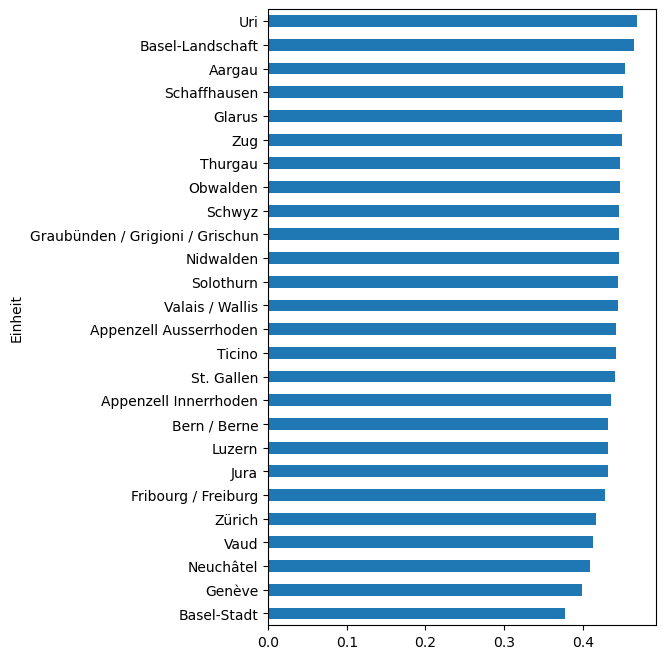

In [48]:
#Sortieren und plotten
df_k_pivot['Verheiratet-Quote'].sort_values().plot(kind='barh', figsize=(5, 8))

**Aufgabe 4:** Zeichnen Sie ein Stacked-Bar-Chart mit den relativen Zivilstands-Anteilen in zwei Gemeinden:
- Corippo
- Meienried

Tipp zu Vorgehen:
1. DF nach Gemeinden filtern und pivotieren
1. Total der Einwohner für jede Gemeinde (in separater Series ablegen)
1. Pivotiertes DF mit `div()` durch das Total dividieren (`axis=1`)
1. mit `.loc[]` die beiden Gemeinden wählen
1. Plot mit `stacked=True`

In [49]:
# DF nach gemeinden filtern und pivotieren
df_g_pivot = df[df['Typ'] == 'Gemeinde'].pivot(index='Einheit', columns='Zivilstand', values='Anzahl')

In [50]:
# Total der Einwohner für jede Gemeinde
s_totals = df_g_pivot.sum(axis=1)

In [51]:
# Neues DF mit relativen Werten
df_g_pivot_rel = df_g_pivot.div(s_totals, axis=0)

In [52]:
# Nur Meienried und Corippo anzeigen
df_g_pivot_rel.loc[['Meienried', 'Corippo']]

Zivilstand,Geschieden,Ledig,Verheiratet,Verwitwet
Einheit,,,,
Meienried,0.057692,0.307692,0.634615,0.000000
Corippo,0.230769,0.384615,0.153846,0.230769


<AxesSubplot:ylabel='Einheit'>

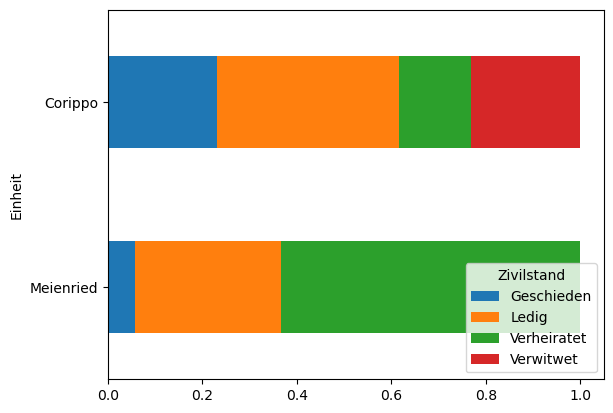

In [53]:
# Plot
df_g_pivot_rel.loc[['Meienried', 'Corippo']].plot(kind='barh', stacked=True)